
# Finding Heavy Traffic Indicators on I-94


This project aims to explore and identify contributing factors to heavier traffic on Westbound I-94 traffic. It will take into account weather, temperature, time of day, and explore any additional unknowns.  

The goal is to identify what causea traffic flow to become heavier during a given period of time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', index_col=False)

traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


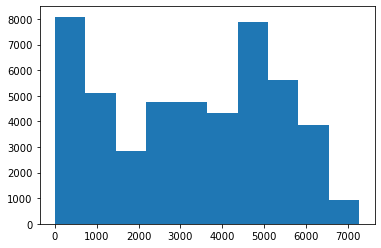

In [4]:
plt.hist(traffic['traffic_volume'])
plt.show()

In [5]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

* It seems the majority of traffic volume is around <1000 and 4900. This tells me traffic tends to stay in the <1000 range, except when it peaks up around 4900. This could be due to time of day.  
* The highest we ever get is 7280, but this is also very uncommon. Perhaps this could be explained by a holiday or some kind of event.  
* The lowest being 0.0 is interesting. This could be due to dead stop traffic from construction or an accident?  

There is probably a difference in day and night time traffic. We'll go ahead and split the data up.

In [6]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic['date_time'].dt.hour

0         9
1        10
2        11
3        12
4        13
         ..
48199    19
48200    20
48201    21
48202    22
48203    23
Name: date_time, Length: 48204, dtype: int64

In [7]:
traffic_hour = traffic['date_time'].dt.hour
day_filter = (traffic_hour >= 7) & (traffic_hour < 19)
# day_filter.describe()

day_traffic = traffic[day_filter]
night_traffic = traffic[~day_filter]

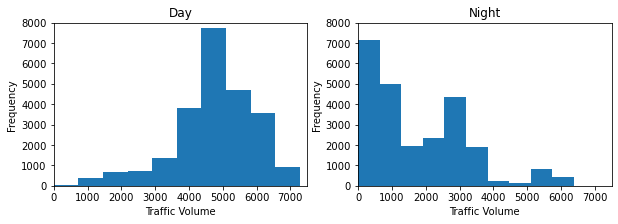

In [44]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(day_traffic['traffic_volume'])
plt.title('Day')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(0, 7500)
plt.ylim(0, 8000)


plt.subplot(1, 2, 2)
plt.hist(night_traffic['traffic_volume'])
plt.title('Night')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(0, 7500)
plt.ylim(0, 8000)

plt.show()

In [46]:
day_traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,23877.000000,23877.00000,23877.000000,23877.000000,23877.000000
mean,282.257596,0.53306,0.000253,53.122000,4762.047452
std,13.298885,63.62932,0.008853,37.564588,1174.546482
min,0.000000,0.00000,0.000000,0.000000,0.000000
25%,272.680000,0.00000,0.000000,5.000000,4252.000000
50%,283.780000,0.00000,0.000000,75.000000,4820.000000
75%,293.440000,0.00000,0.000000,90.000000,5559.000000
max,310.070000,9831.30000,0.510000,100.000000,7280.000000


In [10]:
night_traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,24327.000000,24327.000000,24327.000000,24327.000000,24327.000000
mean,280.173600,0.139145,0.000192,45.672011,1785.377441
std,13.296357,1.110872,0.007434,40.048382,1441.951197
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.700000,0.000000,0.000000,1.000000,530.000000
50%,281.379000,0.000000,0.000000,40.000000,1287.000000
75%,290.700000,0.000000,0.000000,90.000000,2819.000000
max,307.680000,55.630000,0.510000,100.000000,6386.000000


The Day histogram has a left skew indicating a higher volume of traffic during the day. The mean volume during the day is 4762 with a deviation of 1174, meaning most of the day time traffic occurs in hourly chunks from 4000-6000.  
The Night histogram has a pretty strong right skew indicating less traffic during this time period. The most frequent occurences come in the form of small volumes below 2000.  
All this leads me to believe that the vast majority of the traffic comes during the day.
Since the traffic is so light at night, and our goal is to find factors contributing to heavy traffic, I'm going to focus exclusively on day time traffic.  